# Tutorial for BEMB with Simulated Data and the `obs2prior` Option  

Author: Tianyu Du

Update: May. 6, 2022

This tutorial offers a simple simulation exercise to demonstrate how to use BEMB model and the power of BEMB's `obs2prior` feature. We highly recommend you to read the BEMB tutorial first.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch_choice.data import ChoiceDataset
from bemb.model import LitBEMBFlex
from bemb.utils.run_helper import run
import matplotlib.pyplot as plt
import seaborn as sns

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate.
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

Please note that the `data_size` is much smaller than `num_users` $\times$ `num_items` and we are factorizing a spare matrix here.

In [2]:
num_users = 1500
num_items = 50
data_size = 1000

For each of `data_size` purchasing records, we randomly select one user as the decision maker. This information is stored the `user_index` tensor, which has length `data_size`.

In [3]:
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))

We further assign each individual some preferences so that our simulated is **not** totally random.

In particular, for each user $u \in \{1, 2, \dots, num\_users\}$, we assume $u$ particularly loves the item $i^*(u) \in \{0, 1, \dots, num\_item - 1\}$:

$$
i^{love}(u) = \left \lfloor \frac{\sin \left( \frac{u}{num\_users} \times 4 \times \pi \right) + 1}{2} \times num\_items \right \rfloor
$$

The `PREFERENCE` dictionary maps each user $u$ to the item she loves. 

In [4]:
Us = np.arange(num_users)
Is = np.sin(np.arange(num_users) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

Even though the the formula looks complicated, the who-love-what pattern is quite simple.
The figure below draws which item (y-axis) each user (x-axis) likes.

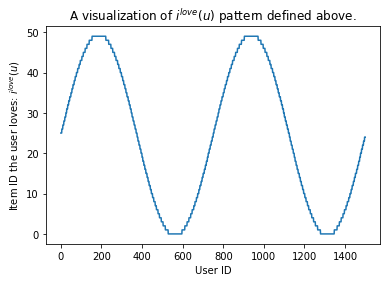

In [5]:
plt.close()
plt.plot(Us, Is)
plt.xlabel('User ID')
plt.ylabel('Item ID the user loves: $i^{love}(u)$')
plt.title('A visualization of $i^{love}(u)$ pattern defined above.')
plt.show()

To add some randomness, for each purchasing records, with 50\% chance, user $u$ chooses the item $i^*(u)$ she loves, and with 50\% of chance she chooses an item randomly.

In [6]:
# construct users.
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))

for idx in range(data_size):
    if np.random.rand() <= 0.5:
        item_index[idx] = PREFERENCE[int(user_index[idx])]

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

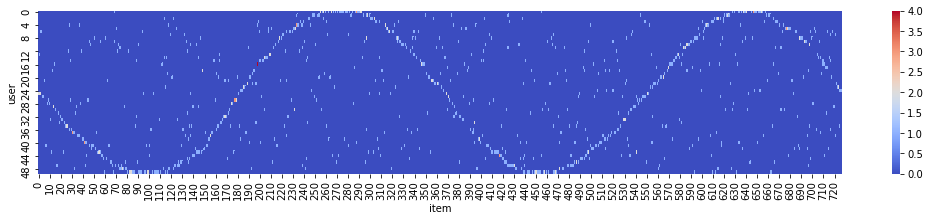

In [7]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='item', ylabel='user')
fig.show()

## Build the `ChoiceDataset` Object
We have created the `user_index` and `item_index` tensors, let's create a dataset object encompassing these tensors. Further, we split the dataset into train-validation-test subsets with ratio 80\%-10\%-10\%.

We wish to add some dummy user observables and item observables to that we can experiment the `obs2prior` feature of BEMB later.

The default item observable is simply the one-hot vector of the item identity.

The observable of a particular user is a one-hot vector with width `num_items` and one on the position of item this user loves (as mentioned previously).

In [8]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

item_obs = torch.eye(num_items)

In [9]:
dataset = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=user_obs, item_obs=item_obs)

idx = np.random.permutation(len(dataset))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size: train_size + val_size]
test_idx = idx[train_size + val_size:]

dataset_list = [dataset[train_idx], dataset[val_idx], dataset[test_idx]]

No `session_index` is provided, assume each choice instance is in its own session.


In [10]:
dataset

ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=cpu)

## Fitting the Model
We will be fitting a Bayesian matrix factorization model with utility form

$$
\mathcal{U}_{u, i} = \theta_u^\top \alpha_i
$$
where $\theta_u$ and $\alpha_i$ are Bayesian variables. Please refer to the BEMB tutorial for a detailed description on how this kind of model works.

There are two options on the prior distributions of these Bayesian variables $\theta_u$ and $\alpha_i$. Firstly, we can simply use standard Gaussian as the prior distribution:

$$
\theta_u \overset{prior}{\sim} \mathcal{N}(\mathbf{0}, I) \\
\alpha_i \overset{prior}{\sim} \mathcal{N}(\mathbf{0}, I)
$$

Alternatively, the prior can be chosen using a data-driven method called `obs2prior`. In particular, the mean of prior distribution can be a learnable linear function of user/item observables. Let $X^{(user)}_u$ and $X^{(item)}_i$ denote the observables of user $u$ and item $i$ respectively. The `obs2prior`-augmented prior distribution is the following: 

$$
\theta_u \overset{prior}{\sim} \mathcal{N}(H X^{(user)}_u, I) \\
\alpha_i \overset{prior}{\sim} \mathcal{N}(W X^{(item)}_i, I)
$$

where $H$ and $W$ are two learnable parameters.

In [11]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')
       
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = run(bemb, dataset_list, batch_size=len(dataset) // 20, num_epochs=50)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    ax.set_title(f'obs2prior = {obs2prior}')
    fig.show()

BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 31.0 K
-----------------------------------
31.0 K    Trainable params
0         Non-trainable params
31.0 K    Total params
0.124     Total estimated model params size (MB)


==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 31000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(0, I))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(0, I))
)
[]
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[800], user_index=[800], session_index=[800], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[100], user_index=[100], session_index=[100], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=cpu)
[Testing dataset] ChoiceDataset(label=[], item_index=[100], user_index=[100], session_index=[100], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=cpu)
==================== train the m

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 40.19812321662903
==================== test performance ====================


Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.02
         test_ll            -3.912011494636536
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


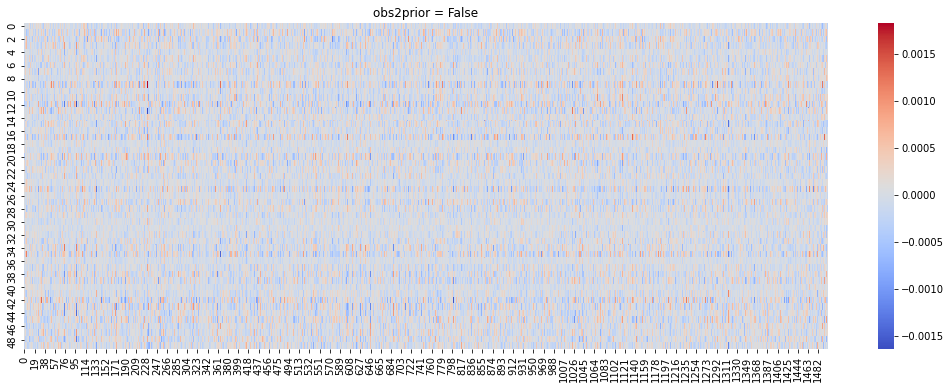

In [12]:
fit_model(obs2prior=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 33.0 K
-----------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 33000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(H*X_obs(H shape=torch.Size([10, 50]), X_obs shape=50), Ix1.0))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(H*X_obs(H shape=torch.Size([10, 50]), X_obs shape=50), Ix1.0))
)
[]
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[800], user_index=[800], session_index=[800], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[100], user_index=[100], session_index=[100], item_availability=[], user_obs=[1500, 50], item_obs=[50, 50], device=

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 40.98820662498474
==================== test performance ====================


Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.47
         test_ll            -3.126977977901697
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


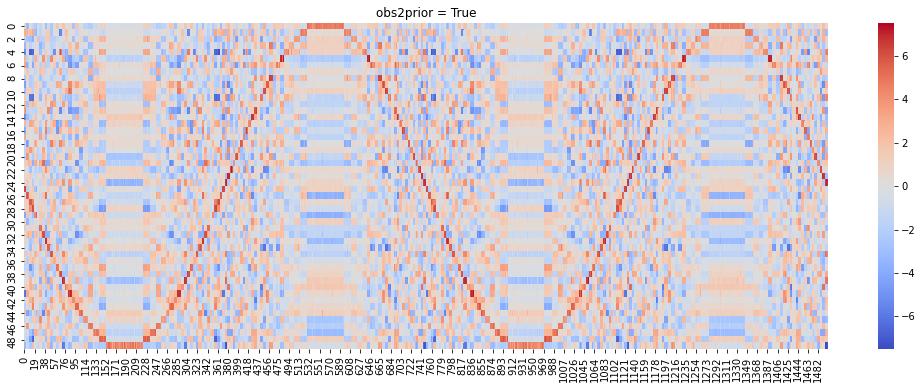

In [13]:
fit_model(obs2prior=True)

Now we compare the difference between two options of prior distributions. We provide a `fit_model` helper function to train and visualize the model. You can go through `fit_model` method to have a preliminary understanding on how to train a BEMB model.

**Visualization**: The method visualize the fitted model by plotting $\theta_u^\top \alpha_i$ for all pairs of user $u$ and item $i$ on a heat map. The sine-curve on the heat map indicates the model successfully recovered the preference pattern we added.